In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import yfinance as yf
start_date = '2022-01-01'
end_date = '2023-03-15'
ticker = 'UBS'
df = yf.download(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


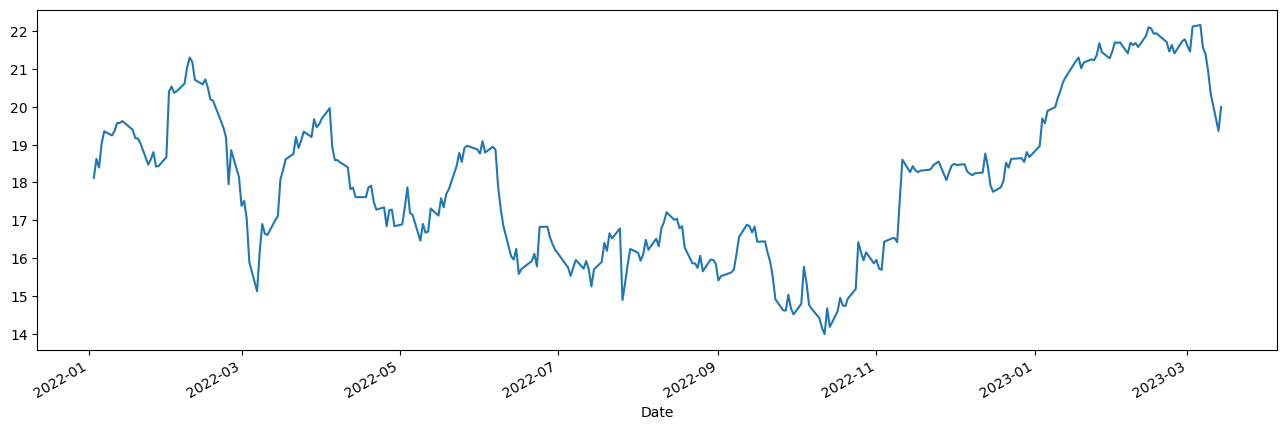

In [5]:
ax = df['Close'].plot(figsize=(16,5))
ax.autoscale(axis='Date',tight=True)

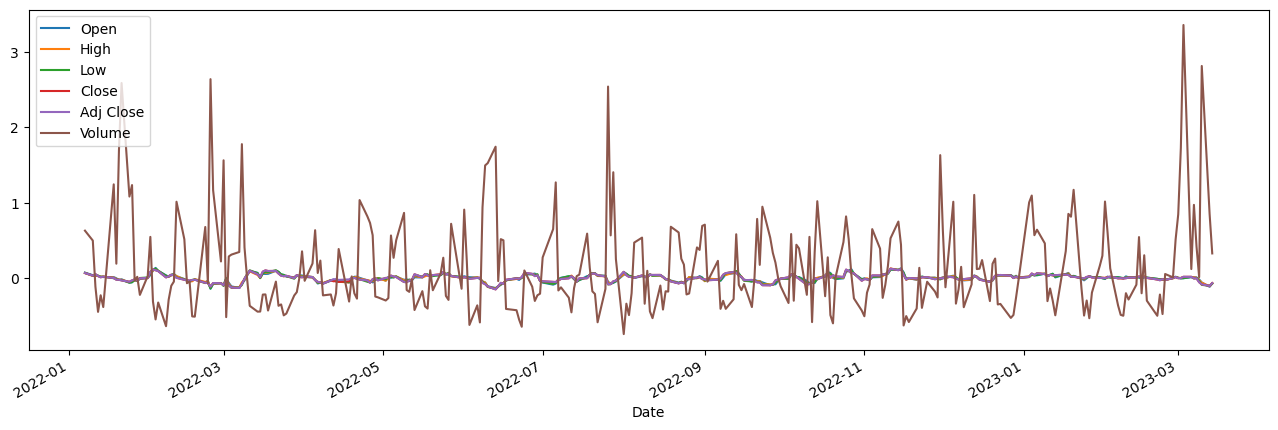

In [6]:
ax = df.pct_change(4).plot(figsize=(16,5))
ax.autoscale(axis='Date',tight=True)

In [7]:
df4 = df.pct_change(4)
df4.dropna(inplace=True)
df4

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-07,0.073415,0.067437,0.070117,0.067881,0.067881,0.629186
2022-01-10,0.039459,0.030002,0.033297,0.033297,0.033297,0.497863
2022-01-11,0.031618,0.034685,0.045529,0.052746,0.052746,-0.112579
2022-01-12,0.028013,0.028871,0.035429,0.028917,0.028917,-0.446343
2022-01-13,0.021244,0.020371,0.016381,0.011369,0.011370,-0.226208
...,...,...,...,...,...,...
2023-03-08,0.009868,0.004658,0.003534,-0.003262,-0.003262,0.415968
2023-03-09,-0.017471,-0.028339,-0.036473,-0.053797,-0.053798,0.012846
2023-03-10,-0.057658,-0.060454,-0.088566,-0.082130,-0.082130,2.809948


<AxesSubplot:xlabel='Date'>

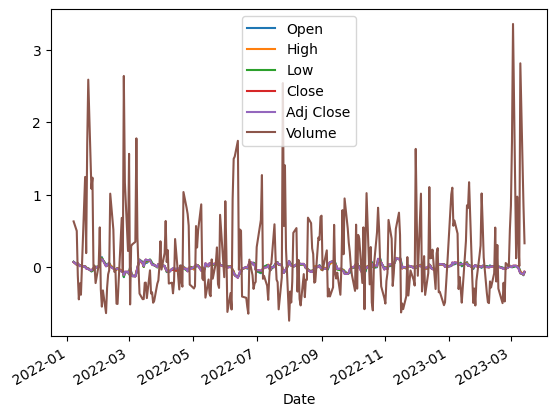

In [60]:
df4.plot()

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
from tensorflow.keras.layers import Dense, Dropout
import seaborn as sns

In [10]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 296 entries, 2022-01-07 to 2023-03-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       296 non-null    float64
 1   High       296 non-null    float64
 2   Low        296 non-null    float64
 3   Close      296 non-null    float64
 4   Adj Close  296 non-null    float64
 5   Volume     296 non-null    float64
dtypes: float64(6)
memory usage: 16.2 KB


df4.reset_index(inplace=True)

In [11]:
from sklearn.preprocessing import MinMaxScaler

<AxesSubplot:xlabel='Date'>

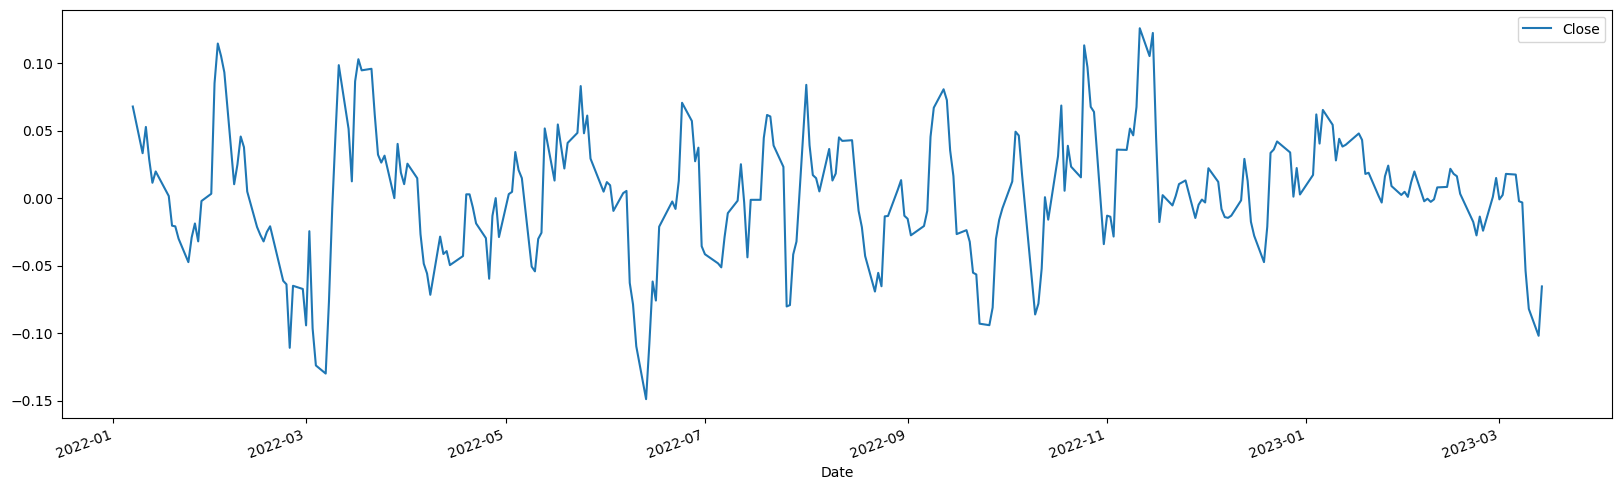

In [13]:
# StockData['TradeDate']=df4.Date
 
# Plotting the stock prices
%matplotlib inline
Series.plot( y='Close', kind='line', figsize=(20,6), rot=20)

### Forecasting with the selection of the Testset range
The model does not see the selected backtimesteps and futretimestep

In [98]:
Series = pd.DataFrame(df4['Close'])

TimeSteps = 12
FutureTimeSteps = 6

# select testset that won't be included in the trianing set
start_point_test = pd.to_datetime('2023-01-01')
# test set only
df_test1 = Series.loc[pd.to_datetime(start_point_test):,:][:TimeSteps+FutureTimeSteps]
df_test1_X = df_test1[:TimeSteps]
df_test1_y = df_test1[-FutureTimeSteps:]

# Series data without testset; TimeSteps and FutureTimeSteps of the selected test range are excluded 
Series = pd.concat([Series[:df_test1.index[0]+pd.DateOffset(-1)], Series[df_test1.index[-1]+pd.DateOffset(1):]])
RawData=Series[['Close']].values
print(RawData[0:5])
RawTest=df_test1_X[['Close']].values
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
# Choosing between Standardization or normalization
sc = StandardScaler()
#sc=MinMaxScaler()
 
DataScaler = sc.fit(RawData)
X=DataScaler.transform(RawData)
X_test = DataScaler.transform(RawTest)
#X_test=X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
#X=FullData
 
print('### After Normalization ###')
X[0:5]

[[0.06788077]
 [0.03329747]
 [0.05274613]
 [0.02891689]
 [0.01136947]]
### After Normalization ###


array([[1.4143048 ],
       [0.68992362],
       [1.09729485],
       [0.59816802],
       [0.23062012]])

In [99]:
X_samples = list()
y_samples = list()


TimeSteps=12  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=6 # How many days in future you want to predict the prices


# X[:-6] - get back in the time; get rid of the last period 
train = X#[:-(FutureTimeSteps)]
# train[-12:] - use the last period of available data (training set)
#test_X_for_preds = train[-TimeSteps:]
# X[-6:] - compare with true future valiable, unavailable for training set
#test_y_actuals = X[-FutureTimeSteps:]
#df_test_y_actuals = pd.DataFrame( X[-FutureTimeSteps:], index=Series.index[-FutureTimeSteps:])

# Reshape the Input as a 3D (samples, Back Time Steps, Features); Features is always 1 for time series - 1 variable
#test_X_for_preds = test_X_for_preds.reshape(1, TimeSteps, 1)
# Reshape the Output as a 2D (samples, Future Time Steps)
#test_y_actuals = test_y_actuals.reshape(test_samples, FutureTimeSteps)

NumerOfRows = len(train)

df_x_samples = pd.DataFrame()
df_y_samples = pd.DataFrame() 

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = train[i-TimeSteps:i]
    y_sample = train[i:i+FutureTimeSteps]
    df_x_samples = pd.concat( [df_x_samples, pd.DataFrame(x_sample, index=Series.index[i-TimeSteps:i])])
    df_y_samples = pd.concat( [df_y_samples, pd.DataFrame(y_sample, index=Series.index[i:i+FutureTimeSteps])])
    X_samples.append(x_sample)
    y_samples.append(y_sample)
    
    
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0],y_data.shape[1])

print('### Output Data Shape ###') 
print(y_data.shape)

df_X_train = df_x_samples
df_y_train = df_y_samples
X_train=X_data
y_train=y_data

### Input Data Shape ###
(260, 12, 1)
### Output Data Shape ###
(260, 6)


In [20]:
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)

[[ 1.37435119]
 [ 0.67214634]
 [ 1.06704624]
 [ 0.58319976]
 [ 0.22690403]
 [ 0.39708014]
 [ 0.0275125 ]
 [-0.41896748]
 [-0.42934316]
 [-0.61454139]
 [-0.96735212]
 [-0.59709801]]
====>
[-0.38545953 -0.65481218 -0.04792254  0.06151321  1.72411336  2.32194643]
####################
[[ 0.67214634]
 [ 1.06704624]
 [ 0.58319976]
 [ 0.22690403]
 [ 0.39708014]
 [ 0.0275125 ]
 [-0.41896748]
 [-0.42934316]
 [-0.61454139]
 [-0.96735212]
 [-0.59709801]
 [-0.38545953]]
====>
[-0.65481218 -0.04792254  0.06151321  1.72411336  2.32194643  2.13339152]
####################


In [101]:

# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 12
Number of Features: 1


In [107]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 12, activation = 'tanh', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second hidden layer and the LSTM layer
#regressor.add(LSTM(units = 4, activation = 'tanh', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 512, activation = 'tanh', return_sequences=False ))
 
# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
###################################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 3, epochs = 5)
 
EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/5
87/87 [==============================] - 6s 42ms/step - loss: 0.9724
Epoch 2/5
87/87 [==============================] - 4s 42ms/step - loss: 0.9326
Epoch 3/5
87/87 [==============================] - 4s 42ms/step - loss: 0.9148
Epoch 4/5
87/87 [==============================] - 4s 42ms/step - loss: 0.8774
Epoch 5/5
87/87 [==============================] - 4s 43ms/step - loss: 0.8636
############### Total Time Taken:  0 Minutes #############


In [108]:

# Making predictions on test data
predicted_Price = regressor.predict((X_test.reshape(1, 12, 1)))
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)
 
# Getting the original price values for testing data
orig=df_test1_y
#orig=DataScaler.inverse_transform(orig)
print('\n#### Original Prices ####')
print(orig)

1/1 [==============================] - 1s 530ms/step
#### Predicted Prices ####
[[ 0.0058877  -0.00060426 -0.00501499 -0.00680586 -0.00663866 -0.0091584 ]]

#### Original Prices ####
               Close
Date                
2023-01-20  0.018768
2023-01-23  0.001886
2023-01-24 -0.003286
2023-01-25  0.016175
2023-01-26  0.024091
2023-01-27  0.008941


<AxesSubplot:xlabel='Date'>

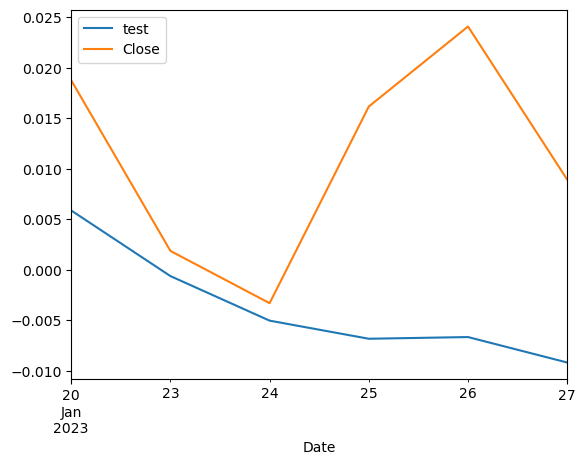

In [109]:
ax = pd.DataFrame(predicted_Price[0],index=orig.index, columns=['test']).plot()
orig.plot(ax=ax)

#### Orginal Time Series

<AxesSubplot:xlabel='Date'>

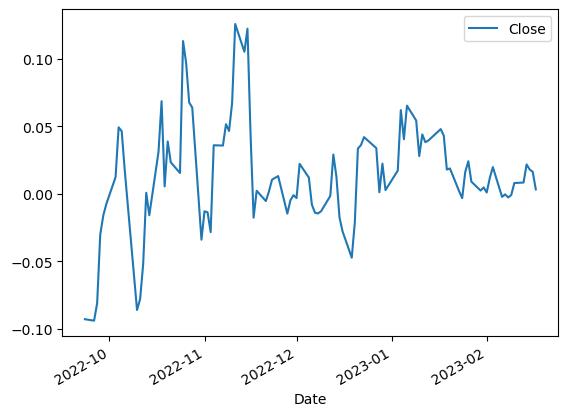

In [112]:
df4[['Close']].loc[start_point_test+pd.DateOffset(-100):start_point_test+pd.DateOffset(50),:].plot()

### Orginal taken Testset (in green) and Predictions (orange) and Actuals (red)

<AxesSubplot:xlabel='Date'>

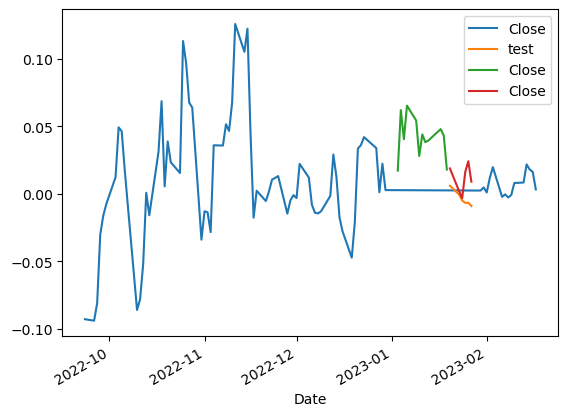

In [111]:
ax = Series.loc[start_point_test+pd.DateOffset(-100):start_point_test+pd.DateOffset(50),:].plot()
pd.DataFrame(predicted_Price[0],index=orig.index, columns=['test']).plot(ax=ax)
df_test1_X.plot(ax=ax)
orig.plot(ax=ax)
